In [1]:
!pip install pubchempy
!pip install rdkit
!pip install plotly

In [2]:
import pandas as pd
import pubchempy as pcp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from rdkit import Chem
from rdkit.Chem import Crippen, rdMolDescriptors
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import requests
import csv
import time
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

**Step 1: 
Filtering Drug Repurposing Results based on Types cp, oe, kd and Scores above 90
Input = export.csv
Output = 3 csv file**

In [ ]:
data = pd.read_csv('export.csv')

# فیلتر کردن سطرهایی که ستون Type برابر با 'cp kd oe' و Score بزرگتر از 90 است
filtered_cp = data[(data['Type'] == 'cp') & (data['Score'] > 90)]
filtered_kd = data[(data['Type'] == 'kd') & (data['Score'] > 90)]
filtered_oe = data[(data['Type'] == 'oe') & (data['Score'] > 90)]
filtered_cc = data[(data['Type'] == 'cc') & (data['Score'] > 90)]

# ذخیره کردن داده‌های فیلتر شده به یک فایل CSV جدید
filtered_cp.to_csv('filtered_cp_above_90.csv', index=False)
filtered_kd.to_csv('filtered_kd_above_90.csv', index=False)
filtered_oe.to_csv('filtered_oe_above_90.csv', index=False)
filtered_cc.to_csv('filtered_cc_above_90.csv', index=False)

print("فایل filtered_cp_above_90.csv با موفقیت ایجاد شد.")
print("فایل filtered_kd_above_90.csv با موفقیت ایجاد شد.")
print("فایل filtered_oe_above_90.csv با موفقیت ایجاد شد.")
print("فایل filtered_cc_above_90.csv با موفقیت ایجاد شد.")

**Step 2
We use filtered_cp_above_90.csv 
Generate 2 Files
CSV file 'compounds.csv' with compounds that have SMILES.
Text file 'molecules_for_adme.txt' for SwissADME input**

In [1]:
# خواندن فایل CSV و فیلتر ردیف‌ها
df = pd.read_csv('filtered_cp_above_90.csv')
filtered_df = df[df['Score'] > 90]

# استخراج لیست نام داروها
drug_names = filtered_df['Name'].tolist()

def get_cid(name):
    url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{name}/cids/JSON'
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        cids = data.get('IdentifierList', {}).get('CID', [])
        if cids:
            return cids[0]
    return None

def get_smiles(cid):
    url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/ConnectivitySMILES/JSON'
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        props = data.get('PropertyTable', {}).get('Properties', [])
        if props and 'ConnectivitySMILES' in props[0]:
            return props[0]['ConnectivitySMILES']
    return None

output = []            # برای ذخیره داده‌های CSV
output_for_adme = []   # برای ذخیره داده‌های فایل متنی SwissADME

for name in drug_names:
    cid = get_cid(name)
    if cid:
        smiles = get_smiles(cid)
        if smiles:
            output.append([name, cid, smiles])
            output_for_adme.append(f"{smiles} {name}")
            print(f"✅ {name}: CID={cid}, SMILES found -> {smiles}")
        else:
            print(f"❌ {name}: SMILES not found for CID {cid}")
    else:
        print(f"❌ {name}: CID not found")
    time.sleep(0.2)  # جلوگیری از محدودیت درخواست‌ها

# ذخیره نتایج فقط برای ردیف‌هایی که SMILES دارند در فایل CSV
with open('compounds.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Compound Name', 'CID', 'SMILES Notation'])
    writer.writerows(output)

print("\nCSV file 'compounds.csv' created successfully with compounds that have SMILES.")

# ذخیره فایل متنی مناسب SwissADME
with open('molecules_for_adme.txt', 'w', encoding='utf-8') as f:
    for line in output_for_adme:
        f.write(line + "\n")

print("Text file 'molecules_for_adme.txt' created successfully for SwissADME input.")

✅ cyclopamine: CID=442972, SMILES found -> CC1CC2C(C(C3(O2)CCC4C5CC=C6CC(CCC6(C5CC4=C3C)C)O)C)NC1
✅ levonorgestrel: CID=13109, SMILES found -> CCC12CCC3C(C1CCC2(C#C)O)CCC4=CC(=O)CCC34
✅ methotrexate: CID=126941, SMILES found -> CN(CC1=CN=C2C(=N1)C(=NC(=N2)N)N)C3=CC=C(C=C3)C(=O)NC(CCC(=O)O)C(=O)O
✅ valdecoxib: CID=119607, SMILES found -> CC1=C(C(=NO1)C2=CC=CC=C2)C3=CC=C(C=C3)S(=O)(=O)N
✅ pyroxamide: CID=4996, SMILES found -> C1=CC(=CN=C1)NC(=O)CCCCCCC(=O)NO
✅ nifekalant: CID=4486, SMILES found -> CN1C(=CC(=O)N(C1=O)C)NCCN(CCCC2=CC=C(C=C2)[N+](=O)[O-])CCO
✅ indinavir: CID=5362440, SMILES found -> CC(C)(C)NC(=O)C1CN(CCN1CC(CC(CC2=CC=CC=C2)C(=O)NC3C(CC4=CC=CC=C34)O)O)CC5=CN=CC=C5
✅ triclosan: CID=5564, SMILES found -> C1=CC(=C(C=C1Cl)O)OC2=C(C=C(C=C2)Cl)Cl
✅ halcinonide: CID=443943, SMILES found -> CC1(OC2CC3C4CCC5=CC(=O)CCC5(C4(C(CC3(C2(O1)C(=O)CCl)C)O)F)C)C
✅ bemesetron: CID=671690, SMILES found -> CN1C2CCC1CC(C2)OC(=O)C3=CC(=CC(=C3)Cl)Cl
✅ profenamine: CID=3290, SMILES found -> CCN(CC)C

**Step 3 After SwissADME**

In [3]:
df = pd.read_csv('swissadme.csv')

print(df.head())

         Molecule                                   Canonical SMILES  \
0     cyclopamine  OC1CCC2(C(=CCC3C2CC2=C(C)C4(CCC32)OC2C(C4C)NCC...   
1  levonorgestrel           C#CC1(O)CCC2C1(CC)CCC1C2CCC2=CC(=O)CCC12   
2    methotrexate  OC(=O)CCC(C(=O)O)NC(=O)c1ccc(cc1)N(Cc1cnc2c(n1...   
3      valdecoxib             Cc1onc(c1c1ccc(cc1)S(=O)(=O)N)c1ccccc1   
4      pyroxamide                        ONC(=O)CCCCCCC(=O)Nc1cccnc1   

       Formula      MW  #Heavy atoms  #Aromatic heavy atoms  Fraction Csp3  \
0    C27H41NO2  411.62            30                      0           0.85   
1     C21H28O2  312.45            23                      0           0.76   
2   C20H22N8O5  454.44            33                     16           0.25   
3  C16H14N2O3S  314.36            22                     17           0.06   
4   C13H19N3O3  265.31            19                      6           0.46   

   #Rotatable bonds  #H-bond acceptors  #H-bond donors  ...  \
0                 0                

In [4]:
df.columns = df.columns.str.strip().str.replace('#', '').str.replace(' ', '_')

In [5]:
print(df.columns)

Index(['Molecule', 'Canonical_SMILES', 'Formula', 'MW', 'Heavy_atoms',
       'Aromatic_heavy_atoms', 'Fraction_Csp3', 'Rotatable_bonds',
       'H-bond_acceptors', 'H-bond_donors', 'MR', 'TPSA', 'iLOGP', 'XLOGP3',
       'WLOGP', 'MLOGP', 'Silicos-IT_Log_P', 'Consensus_Log_P', 'ESOL_Log_S',
       'ESOL_Solubility_(mg/ml)', 'ESOL_Solubility_(mol/l)', 'ESOL_Class',
       'Ali_Log_S', 'Ali_Solubility_(mg/ml)', 'Ali_Solubility_(mol/l)',
       'Ali_Class', 'Silicos-IT_LogSw', 'Silicos-IT_Solubility_(mg/ml)',
       'Silicos-IT_Solubility_(mol/l)', 'Silicos-IT_class', 'GI_absorption',
       'BBB_permeant', 'Pgp_substrate', 'CYP1A2_inhibitor',
       'CYP2C19_inhibitor', 'CYP2C9_inhibitor', 'CYP2D6_inhibitor',
       'CYP3A4_inhibitor', 'log_Kp_(cm/s)', 'Lipinski_violations',
       'Ghose_violations', 'Veber_violations', 'Egan_violations',
       'Muegge_violations', 'Bioavailability_Score', 'PAINS_alerts',
       'Brenk_alerts', 'Leadlikeness_violations', 'Synthetic_Accessibility'],
  

In [6]:
# نمایش نوع داده هر ستون
print("نوع داده هر ستون در DataFrame:")
print(df.dtypes)

نوع داده هر ستون در DataFrame:
Molecule                          object
Canonical_SMILES                  object
Formula                           object
MW                               float64
Heavy_atoms                        int64
Aromatic_heavy_atoms               int64
Fraction_Csp3                    float64
Rotatable_bonds                    int64
H-bond_acceptors                   int64
H-bond_donors                      int64
MR                               float64
TPSA                             float64
iLOGP                            float64
XLOGP3                           float64
WLOGP                            float64
MLOGP                            float64
Silicos-IT_Log_P                 float64
Consensus_Log_P                  float64
ESOL_Log_S                       float64
ESOL_Solubility_(mg/ml)          float64
ESOL_Solubility_(mol/l)          float64
ESOL_Class                        object
Ali_Log_S                        float64
Ali_Solubility_(mg/ml)    

In [7]:
text_columns = df.select_dtypes(include=['object']).columns
print("ستون‌های متنی (object):")
print(text_columns)

ستون‌های متنی (object):
Index(['Molecule', 'Canonical_SMILES', 'Formula', 'ESOL_Class', 'Ali_Class',
       'Silicos-IT_class', 'GI_absorption', 'BBB_permeant', 'Pgp_substrate',
       'CYP1A2_inhibitor', 'CYP2C19_inhibitor', 'CYP2C9_inhibitor',
       'CYP2D6_inhibitor', 'CYP3A4_inhibitor'],
      dtype='object')


In [8]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
print("ستون‌های عددی:")
print(numeric_columns)

ستون‌های عددی:
Index(['MW', 'Heavy_atoms', 'Aromatic_heavy_atoms', 'Fraction_Csp3',
       'Rotatable_bonds', 'H-bond_acceptors', 'H-bond_donors', 'MR', 'TPSA',
       'iLOGP', 'XLOGP3', 'WLOGP', 'MLOGP', 'Silicos-IT_Log_P',
       'Consensus_Log_P', 'ESOL_Log_S', 'ESOL_Solubility_(mg/ml)',
       'ESOL_Solubility_(mol/l)', 'Ali_Log_S', 'Ali_Solubility_(mg/ml)',
       'Ali_Solubility_(mol/l)', 'Silicos-IT_LogSw',
       'Silicos-IT_Solubility_(mg/ml)', 'Silicos-IT_Solubility_(mol/l)',
       'log_Kp_(cm/s)', 'Lipinski_violations', 'Ghose_violations',
       'Veber_violations', 'Egan_violations', 'Muegge_violations',
       'Bioavailability_Score', 'PAINS_alerts', 'Brenk_alerts',
       'Leadlikeness_violations', 'Synthetic_Accessibility'],
      dtype='object')


In [9]:
# تبدیل ستون‌هایی که باید عددی باشند (اگر نیاز باشد)
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# برخی ستون‌ها ممکن است به صورت رشته باشند، سعی می‌کنیم تبدیل کنیم
for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        pass

In [10]:
# بررسی داده‌های گمشده
print(df.isnull().sum())

Molecule                         0
Canonical_SMILES                 0
Formula                          0
MW                               0
Heavy_atoms                      0
Aromatic_heavy_atoms             0
Fraction_Csp3                    0
Rotatable_bonds                  0
H-bond_acceptors                 0
H-bond_donors                    0
MR                               0
TPSA                             0
iLOGP                            0
XLOGP3                           0
WLOGP                            0
MLOGP                            0
Silicos-IT_Log_P                 0
Consensus_Log_P                  0
ESOL_Log_S                       0
ESOL_Solubility_(mg/ml)          0
ESOL_Solubility_(mol/l)          0
ESOL_Class                       0
Ali_Log_S                        0
Ali_Solubility_(mg/ml)           0
Ali_Solubility_(mol/l)           0
Ali_Class                        0
Silicos-IT_LogSw                 0
Silicos-IT_Solubility_(mg/ml)    0
Silicos-IT_Solubilit

In [11]:
# حذف ردیف‌هایی با داده‌های عددی ناقص
df_clean = df.dropna(subset=numeric_cols)

print(f"Shape after cleaning: {df_clean.shape}")

Shape after cleaning: (45, 49)


In [58]:
# نمایش نام ستون‌ها برای اطمینان
print(df_clean.columns.tolist())

['Molecule', 'Canonical_SMILES', 'Formula', 'MW', 'Heavy_atoms', 'Aromatic_heavy_atoms', 'Fraction_Csp3', 'Rotatable_bonds', 'H-bond_acceptors', 'H-bond_donors', 'MR', 'TPSA', 'iLOGP', 'XLOGP3', 'WLOGP', 'MLOGP', 'Silicos-IT_Log_P', 'Consensus_Log_P', 'ESOL_Log_S', 'ESOL_Solubility_(mg/ml)', 'ESOL_Solubility_(mol/l)', 'ESOL_Class', 'Ali_Log_S', 'Ali_Solubility_(mg/ml)', 'Ali_Solubility_(mol/l)', 'Ali_Class', 'Silicos-IT_LogSw', 'Silicos-IT_Solubility_(mg/ml)', 'Silicos-IT_Solubility_(mol/l)', 'Silicos-IT_class', 'GI_absorption', 'BBB_permeant', 'Pgp_substrate', 'CYP1A2_inhibitor', 'CYP2C19_inhibitor', 'CYP2C9_inhibitor', 'CYP2D6_inhibitor', 'CYP3A4_inhibitor', 'log_Kp_(cm/s)', 'Lipinski_violations', 'Ghose_violations', 'Veber_violations', 'Egan_violations', 'Muegge_violations', 'Bioavailability_Score', 'PAINS_alerts', 'Brenk_alerts', 'Leadlikeness_violations', 'Synthetic_Accessibility']


In [12]:
# شناسایی ستون‌های object به جز موارد خاص
columns_to_encode = df.select_dtypes(include=['object']).columns
columns_to_encode = [col for col in columns_to_encode if col not in ['Molecule', 'Canonical_SMILES', 'Formula']]

print("ستون‌هایی که باید وان هات انکود شوند:")
print(columns_to_encode)

ستون‌هایی که باید وان هات انکود شوند:
['ESOL_Class', 'Ali_Class', 'Silicos-IT_class', 'GI_absorption', 'BBB_permeant', 'Pgp_substrate', 'CYP1A2_inhibitor', 'CYP2C19_inhibitor', 'CYP2C9_inhibitor', 'CYP2D6_inhibitor', 'CYP3A4_inhibitor']


In [13]:
# انجام وان هات انکودینگ روی ستون‌های انتخابی با تبدیل مستقیم به 0 و 1
df_encoded = pd.get_dummies(df, columns=columns_to_encode, drop_first=True, dtype=int)

print("دیتافریم پس از وان هات انکودینگ:")
print(df_encoded.head())

دیتافریم پس از وان هات انکودینگ:
         Molecule                                   Canonical_SMILES  \
0     cyclopamine  OC1CCC2(C(=CCC3C2CC2=C(C)C4(CCC32)OC2C(C4C)NCC...   
1  levonorgestrel           C#CC1(O)CCC2C1(CC)CCC1C2CCC2=CC(=O)CCC12   
2    methotrexate  OC(=O)CCC(C(=O)O)NC(=O)c1ccc(cc1)N(Cc1cnc2c(n1...   
3      valdecoxib             Cc1onc(c1c1ccc(cc1)S(=O)(=O)N)c1ccccc1   
4      pyroxamide                        ONC(=O)CCCCCCC(=O)Nc1cccnc1   

       Formula      MW  Heavy_atoms  Aromatic_heavy_atoms  Fraction_Csp3  \
0    C27H41NO2  411.62           30                     0           0.85   
1     C21H28O2  312.45           23                     0           0.76   
2   C20H22N8O5  454.44           33                    16           0.25   
3  C16H14N2O3S  314.36           22                    17           0.06   
4   C13H19N3O3  265.31           19                     6           0.46   

   Rotatable_bonds  H-bond_acceptors  H-bond_donors  ...  \
0                

In [14]:
# ذخیره دیتافریم پاکسازی‌شده به صورت CSV
output_file = 'cleaned_ohe_data.csv'
df_encoded.to_csv(output_file, index=False)

print(f"دیتافریم پاکسازی‌شده ذخیره شد در فایل: {output_file}")

دیتافریم پاکسازی‌شده ذخیره شد در فایل: cleaned_ohe_data.csv


In [20]:
# نمایش نام ستون‌ها برای اطمینان
print(df.columns.tolist())

['Molecule', 'Canonical_SMILES', 'Formula', 'MW', 'Heavy_atoms', 'Aromatic_heavy_atoms', 'Fraction_Csp3', 'Rotatable_bonds', 'H-bond_acceptors', 'H-bond_donors', 'MR', 'TPSA', 'iLOGP', 'XLOGP3', 'WLOGP', 'MLOGP', 'Silicos-IT_Log_P', 'Consensus_Log_P', 'ESOL_Log_S', 'ESOL_Solubility_(mg/ml)', 'ESOL_Solubility_(mol/l)', 'ESOL_Class', 'Ali_Log_S', 'Ali_Solubility_(mg/ml)', 'Ali_Solubility_(mol/l)', 'Ali_Class', 'Silicos-IT_LogSw', 'Silicos-IT_Solubility_(mg/ml)', 'Silicos-IT_Solubility_(mol/l)', 'Silicos-IT_class', 'GI_absorption', 'BBB_permeant', 'Pgp_substrate', 'CYP1A2_inhibitor', 'CYP2C19_inhibitor', 'CYP2C9_inhibitor', 'CYP2D6_inhibitor', 'CYP3A4_inhibitor', 'log_Kp_(cm/s)', 'Lipinski_violations', 'Ghose_violations', 'Veber_violations', 'Egan_violations', 'Muegge_violations', 'Bioavailability_Score', 'PAINS_alerts', 'Brenk_alerts', 'Leadlikeness_violations', 'Synthetic_Accessibility', 'Target']


In [105]:
print(df_encoded.columns.tolist())

['Molecule', 'Canonical_SMILES', 'Formula', 'MW', 'Heavy_atoms', 'Aromatic_heavy_atoms', 'Fraction_Csp3', 'Rotatable_bonds', 'H-bond_acceptors', 'H-bond_donors', 'MR', 'TPSA', 'iLOGP', 'XLOGP3', 'WLOGP', 'MLOGP', 'Silicos-IT_Log_P', 'Consensus_Log_P', 'ESOL_Log_S', 'ESOL_Solubility_(mg/ml)', 'ESOL_Solubility_(mol/l)', 'Ali_Log_S', 'Ali_Solubility_(mg/ml)', 'Ali_Solubility_(mol/l)', 'Silicos-IT_LogSw', 'Silicos-IT_Solubility_(mg/ml)', 'Silicos-IT_Solubility_(mol/l)', 'log_Kp_(cm/s)', 'Lipinski_violations', 'Ghose_violations', 'Veber_violations', 'Egan_violations', 'Muegge_violations', 'Bioavailability_Score', 'PAINS_alerts', 'Brenk_alerts', 'Leadlikeness_violations', 'Synthetic_Accessibility', 'ESOL_Class_Poorly soluble', 'ESOL_Class_Soluble', 'ESOL_Class_Very soluble', 'Ali_Class_Poorly soluble', 'Ali_Class_Soluble', 'Ali_Class_Very soluble', 'Silicos-IT_class_Poorly soluble', 'Silicos-IT_class_Soluble', 'GI_absorption', 'BBB_permeant', 'Pgp_substrate', 'CYP1A2_inhibitor', 'CYP2C19_inh

In [21]:
print(df_encoded.columns.tolist())

['Molecule', 'Canonical_SMILES', 'Formula', 'MW', 'Heavy_atoms', 'Aromatic_heavy_atoms', 'Fraction_Csp3', 'Rotatable_bonds', 'H-bond_acceptors', 'H-bond_donors', 'MR', 'TPSA', 'iLOGP', 'XLOGP3', 'WLOGP', 'MLOGP', 'Silicos-IT_Log_P', 'Consensus_Log_P', 'ESOL_Log_S', 'ESOL_Solubility_(mg/ml)', 'ESOL_Solubility_(mol/l)', 'Ali_Log_S', 'Ali_Solubility_(mg/ml)', 'Ali_Solubility_(mol/l)', 'Silicos-IT_LogSw', 'Silicos-IT_Solubility_(mg/ml)', 'Silicos-IT_Solubility_(mol/l)', 'log_Kp_(cm/s)', 'Lipinski_violations', 'Ghose_violations', 'Veber_violations', 'Egan_violations', 'Muegge_violations', 'Bioavailability_Score', 'PAINS_alerts', 'Brenk_alerts', 'Leadlikeness_violations', 'Synthetic_Accessibility', 'ESOL_Class_Poorly soluble', 'ESOL_Class_Soluble', 'ESOL_Class_Very soluble', 'Ali_Class_Poorly soluble', 'Ali_Class_Soluble', 'Ali_Class_Very soluble', 'Silicos-IT_class_Poorly soluble', 'Silicos-IT_class_Soluble', 'GI_absorption_Low', 'BBB_permeant_Yes', 'Pgp_substrate_Yes', 'CYP1A2_inhibitor_Ye

In [22]:
# ایجاد دیکشنری برای تغییر نام ستون‌ها
column_mapping = {
    'GI_absorption_Low': 'GI_absorption',
    'BBB_permeant_Yes': 'BBB_permeant',
    'Pgp_substrate_Yes': 'Pgp_substrate',
    'CYP1A2_inhibitor_Yes': 'CYP1A2_inhibitor',
    'CYP2C19_inhibitor_Yes': 'CYP2C19_inhibitor',
    'CYP2C9_inhibitor_Yes': 'CYP2C9_inhibitor',
    'CYP2D6_inhibitor_Yes': 'CYP2D6_inhibitor',
    'CYP3A4_inhibitor_Yes': 'CYP3A4_inhibitor'
}

In [23]:
# تغییر نام ستون‌ها
df_encoded.rename(columns=column_mapping, inplace=True)

print("\nDataFrame بعد از تغییر نام ستون‌ها:")
print(df_encoded.columns)

# نمایش DataFrame برای اطمینان از تغییرات
print("\nنمونه‌ای از داده‌ها:")
print(df_encoded)


DataFrame بعد از تغییر نام ستون‌ها:
Index(['Molecule', 'Canonical_SMILES', 'Formula', 'MW', 'Heavy_atoms',
       'Aromatic_heavy_atoms', 'Fraction_Csp3', 'Rotatable_bonds',
       'H-bond_acceptors', 'H-bond_donors', 'MR', 'TPSA', 'iLOGP', 'XLOGP3',
       'WLOGP', 'MLOGP', 'Silicos-IT_Log_P', 'Consensus_Log_P', 'ESOL_Log_S',
       'ESOL_Solubility_(mg/ml)', 'ESOL_Solubility_(mol/l)', 'Ali_Log_S',
       'Ali_Solubility_(mg/ml)', 'Ali_Solubility_(mol/l)', 'Silicos-IT_LogSw',
       'Silicos-IT_Solubility_(mg/ml)', 'Silicos-IT_Solubility_(mol/l)',
       'log_Kp_(cm/s)', 'Lipinski_violations', 'Ghose_violations',
       'Veber_violations', 'Egan_violations', 'Muegge_violations',
       'Bioavailability_Score', 'PAINS_alerts', 'Brenk_alerts',
       'Leadlikeness_violations', 'Synthetic_Accessibility',
       'ESOL_Class_Poorly soluble', 'ESOL_Class_Soluble',
       'ESOL_Class_Very soluble', 'Ali_Class_Poorly soluble',
       'Ali_Class_Soluble', 'Ali_Class_Very soluble',
       'Sil

In [106]:
# ذخیره دیتافریم پاکسازی‌شده به صورت CSV
output_file = 'df_encoded.csv'
df_encoded.to_csv(output_file, index=False)

In [24]:
# تعریف ستون تارگت بر اساس جذب بالا و سمیت کم
df_encoded['Target'] = ((df_encoded['GI_absorption'] == '1') & (df_encoded['PAINS_alerts'] == 0)).astype(int)

print("ایجاد ستون تارگت:")
print(df_encoded[['GI_absorption', 'PAINS_alerts', 'Target']].head())

ایجاد ستون تارگت:
   GI_absorption  PAINS_alerts  Target
0              0             0       0
1              0             0       0
2              1             0       0
3              0             0       0
4              0             0       0


In [ ]:
# جدا کردن ستون تارگت
# PAINS_alerts
target = df_encoded['Target']
features = df_encoded.drop('Target', axis=1)

# اکنون می‌توانید مدل‌سازی را آغاز کنید

In [26]:
# انتخاب ستون‌های عددی
numeric_cols = df_encoded.select_dtypes(include=['float64', 'int64']).columns
df_numeric = df_encoded[numeric_cols]

In [27]:
df_numeric

,MW,Heavy_atoms,Aromatic_heavy_atoms,Fraction_Csp3,Rotatable_bonds,H-bond_acceptors,H-bond_donors,MR,TPSA,iLOGP,...,Silicos-IT_class_Poorly soluble,Silicos-IT_class_Soluble,GI_absorption_Low,BBB_permeant_Yes,Pgp_substrate_Yes,CYP1A2_inhibitor_Yes,CYP2C19_inhibitor_Yes,CYP2C9_inhibitor_Yes,CYP2D6_inhibitor_Yes,CYP3A4_inhibitor_Yes
0,411.62,30,0,0.85,0,3,2,127.01,41.49,4.27,...,0,0,0,1,1,0,0,0,0,0
1,312.45,23,0,0.76,1,2,1,93.43,37.30,3.16,...,0,1,0,1,0,0,0,1,0,0
2,454.44,33,16,0.25,10,9,5,118.40,210.54,1.01,...,0,1,1,0,0,0,0,0,0,0
3,314.36,22,17,0.06,3,5,1,83.34,94.57,1.78,...,1,0,0,0,0,1,0,0,0,1
4,265.31,19,6,0.46,10,4,3,71.12,91.32,1.93,...,0,1,0,0,1,0,0,0,0,0
5,405.45,29,12,0.47,11,6,2,113.00,125.32,3.22,...,0,0,0,0,1,0,0,0,0,0
6,613.79,45,18,0.47,14,7,4,182.62,118.03,3.95,...,1,0,0,0,1,0,0,0,0,0
7,289.54,17,12,0.00,2,2,1,70.01,29.46,2.98,...,0,0,0,1,0,1,1,1,0,0
8,454.96,31,0,0.83,2,6,1,114.61,72.83,3.11,...,0,0,0,1,1,0,0,0,0,0
9,314.21,20,6,0.53,3,3,0,83.97,29.54,2.95,...,0,0,0,1,0,1,1,1,1,0


In [28]:
# مقیاس‌بندی ستون‌های عددی
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_numeric)

# تبدیل به دیتافریم مقیاس‌بندی شده
df_scaled = pd.DataFrame(scaled_features, columns=numeric_cols)

print("دیتافریم مقیاس‌بندی شده:")
print(df_scaled.head())

دیتافریم مقیاس‌بندی شده:
         MW  Heavy_atoms  Aromatic_heavy_atoms  Fraction_Csp3  \
0  0.500896     0.674218             -1.796742       2.070838   
1 -0.422624    -0.253200             -1.796742       1.694406   
2  0.899657     1.071683              0.859632      -0.438705   
3 -0.404837    -0.385688              1.025656      -1.233394   
4 -0.861614    -0.783153             -0.800602       0.439635   

   Rotatable_bonds  H-bond_acceptors  H-bond_donors        MR      TPSA  \
0        -1.237811         -0.509797       0.225877  0.924058 -0.750045   
1        -0.986904         -0.898624      -0.451754 -0.203891 -0.837854   
2         1.271266          1.823171       2.258770  0.634849  2.792686   
3        -0.485088          0.267859      -0.451754 -0.542812  0.362337   
4         1.271266         -0.120969       0.903508 -0.953281  0.294227   

      iLOGP  ...  Silicos-IT_class_Poorly soluble  Silicos-IT_class_Soluble  \
0  1.451052  ...                        -0.779194     

In [29]:
df_scaled

,MW,Heavy_atoms,Aromatic_heavy_atoms,Fraction_Csp3,Rotatable_bonds,H-bond_acceptors,H-bond_donors,MR,TPSA,iLOGP,...,Silicos-IT_class_Poorly soluble,Silicos-IT_class_Soluble,GI_absorption_Low,BBB_permeant_Yes,Pgp_substrate_Yes,CYP1A2_inhibitor_Yes,CYP2C19_inhibitor_Yes,CYP2C9_inhibitor_Yes,CYP2D6_inhibitor_Yes,CYP3A4_inhibitor_Yes
0,0.500896,0.674218,-1.796742,2.070838,-1.237811,-0.509797,0.225877,0.924058,-0.750045,1.451052,...,-0.779194,-0.672022,-0.429198,0.894427,1.346291,-0.854850,-0.816497,-0.978019,-0.742781,-0.854850
1,-0.422624,-0.253200,-1.796742,1.694406,-0.986904,-0.898624,-0.451754,-0.203891,-0.837854,0.326982,...,-0.779194,1.488048,-0.429198,0.894427,-0.742781,-0.854850,-0.816497,1.022475,-0.742781,-0.854850
2,0.899657,1.071683,0.859632,-0.438705,1.271266,1.823171,2.258770,0.634849,2.792686,-1.850271,...,-0.779194,1.488048,2.329929,-1.118034,-0.742781,-0.854850,-0.816497,-0.978019,-0.742781,-0.854850
3,-0.404837,-0.385688,1.025656,-1.233394,-0.485088,0.267859,-0.451754,-0.542812,0.362337,-1.070511,...,1.283378,-0.672022,-0.429198,-1.118034,-0.742781,1.169795,-0.816497,-0.978019,-0.742781,1.169795
4,-0.861614,-0.783153,-0.800602,0.439635,1.271266,-0.120969,0.903508,-0.953281,0.294227,-0.918609,...,-0.779194,1.488048,-0.429198,-1.118034,1.346291,-0.854850,-0.816497,-0.978019,-0.742781,-0.854850
5,0.443438,0.541730,0.195539,0.481460,1.522173,0.656687,0.225877,0.453463,1.006755,0.387742,...,-0.779194,-0.672022,-0.429198,-1.118034,1.346291,-0.854850,-0.816497,-0.978019,-0.742781,-0.854850
6,2.383603,2.661542,1.191679,0.481460,2.274896,1.045515,1.581139,2.791991,0.853981,1.126995,...,1.283378,-0.672022,-0.429198,-1.118034,1.346291,-0.854850,-0.816497,-0.978019,-0.742781,-0.854850
7,-0.635973,-1.048129,0.195539,-1.484348,-0.735996,-0.898624,-0.451754,-0.990566,-1.002154,0.144700,...,-0.779194,-0.672022,-0.429198,0.894427,-0.742781,1.169795,1.224745,1.022475,-0.742781,-0.854850
8,0.904500,0.806706,-1.796742,1.987186,-0.735996,0.656687,-0.451754,0.507543,-0.093262,0.276348,...,-0.779194,-0.672022,-0.429198,0.894427,1.346291,-0.854850,-0.816497,-0.978019,-0.742781,-0.854850
9,-0.406234,-0.650665,-0.800602,0.732415,-0.485088,-0.509797,-1.129385,-0.521651,-1.000478,0.114320,...,-0.779194,-0.672022,-0.429198,0.894427,-0.742781,1.169795,1.224745,1.022475,1.346291,-0.854850


In [30]:
# ذخیره دیتافریم مقیاس‌بندی شده در فایل CSV
df_scaled.to_csv('scaled_swissadme.csv', index=False)

In [53]:
# انتخاب ویژگی‌ها با نام‌های جدید
features_to_plot = ['MW', 'Heavy_atoms','Rotatable_bonds',
       'H-bond_acceptors', 'H-bond_donors', 'TPSA',
       'WLOGP', 'ESOL_Log_S','PAINS_alerts']

In [54]:
print(len(features_to_plot))

9


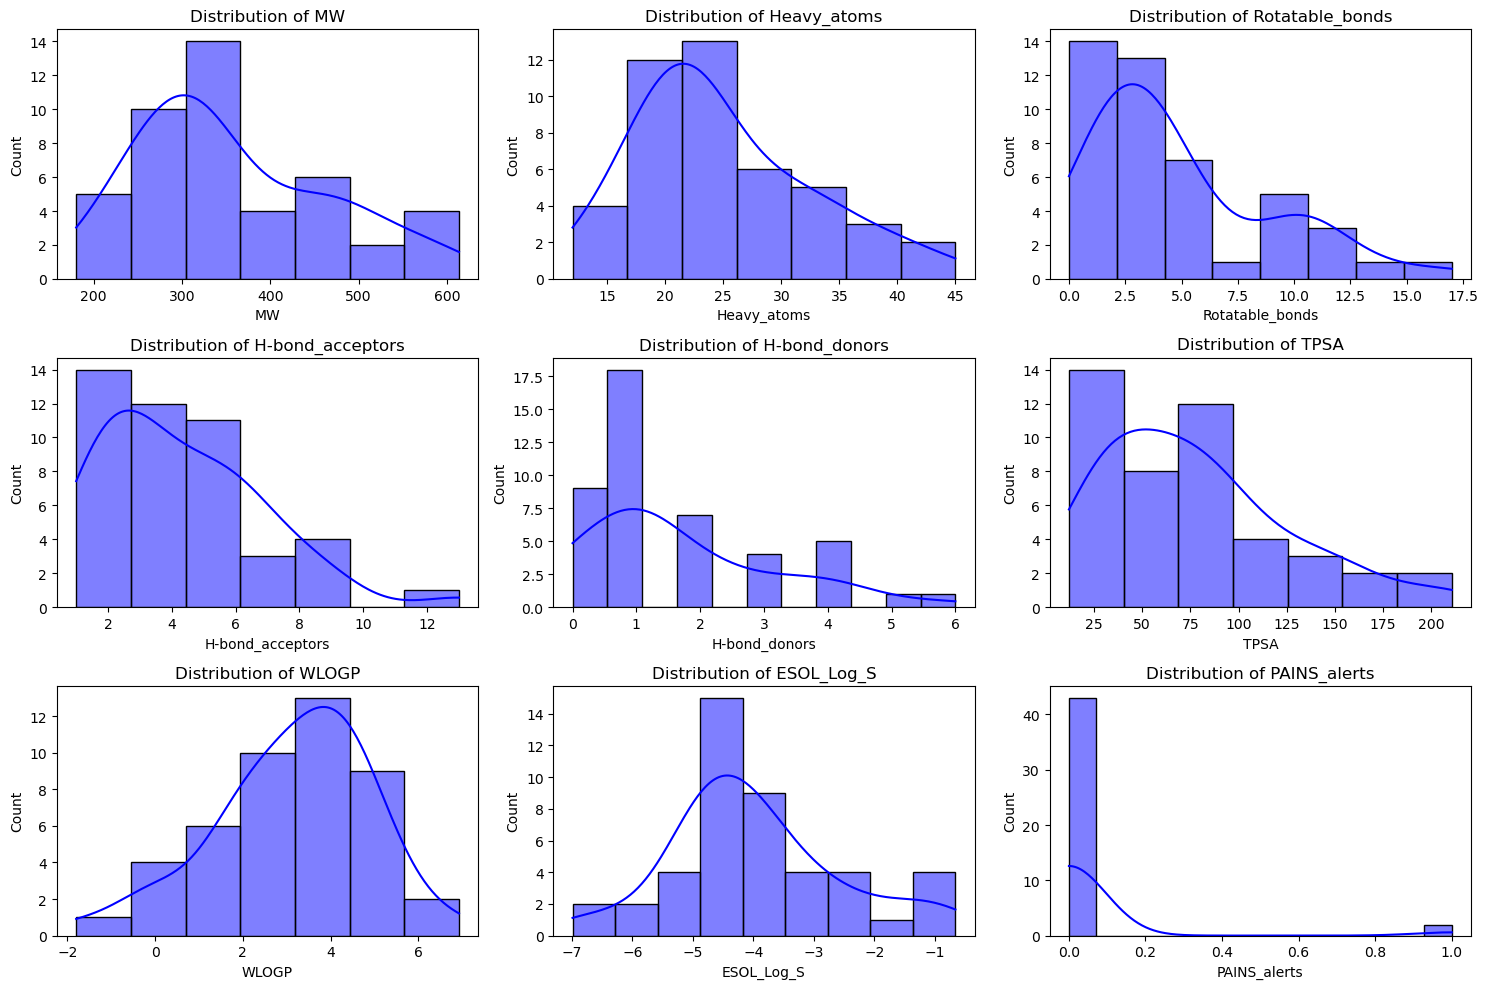

In [55]:
# ==== ترسیم هیستوگرام برای توزیع ویژگی‌ها ====

plt.figure(figsize=(15,10))
for i, feature in enumerate(features_to_plot):
    plt.subplot(3, 3, i+1)
    sns.histplot(df_clean[feature], kde=True, color='blue')
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

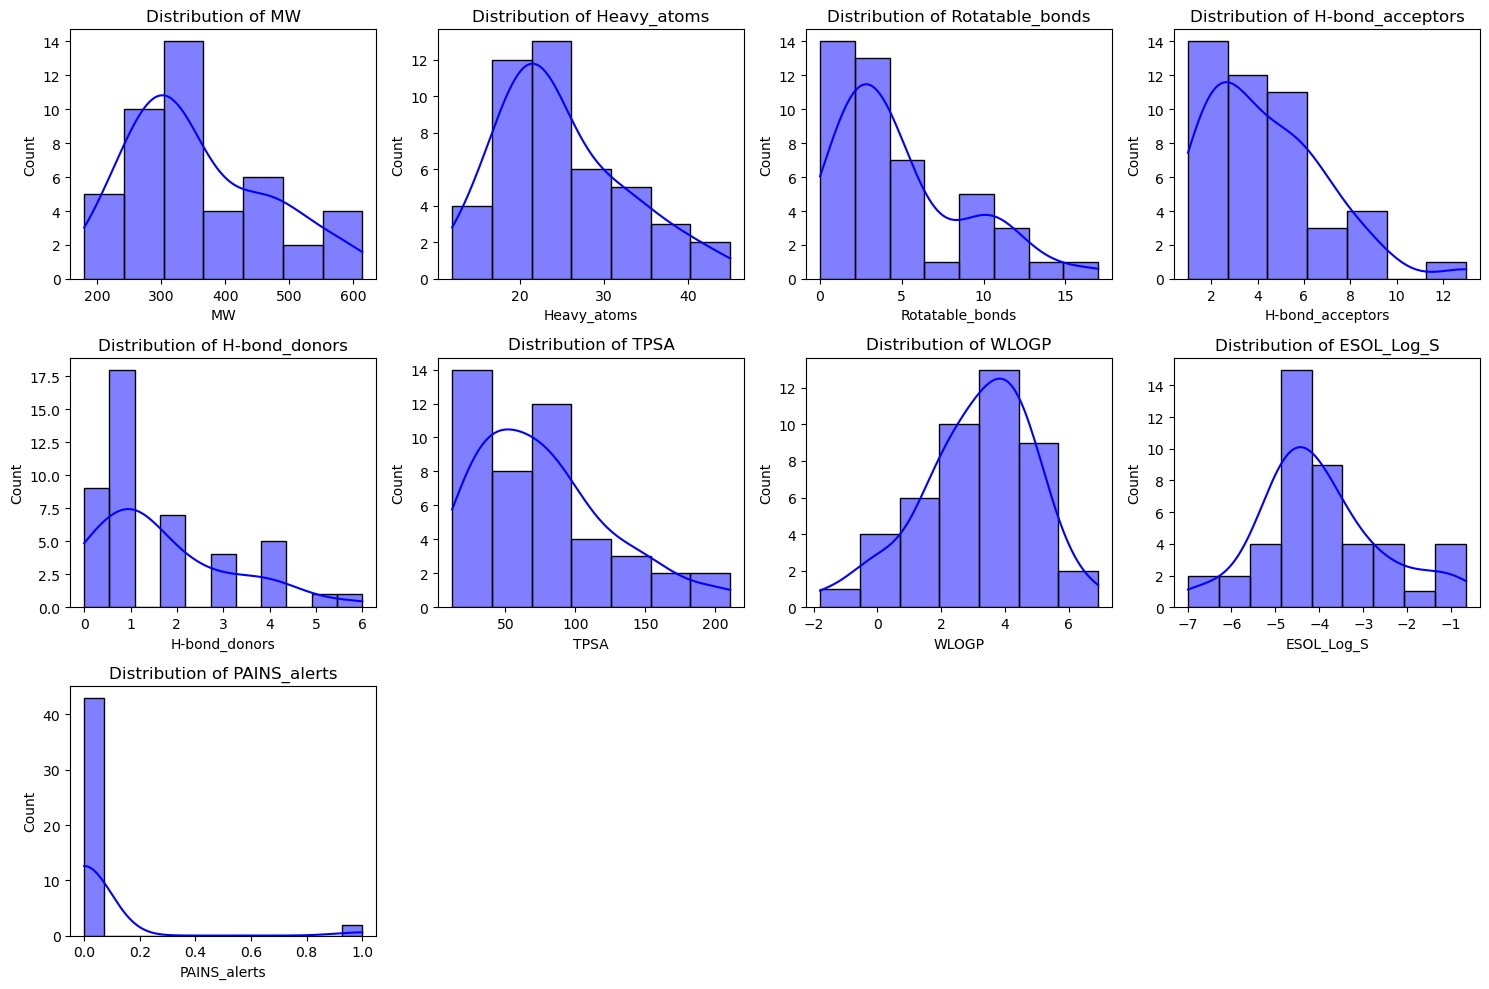

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# تعریف تعداد ردیف‌ها و ستون‌ها بر اساس تعداد ویژگی‌ها
num_features = len(features_to_plot)
num_rows = (num_features // 4) + (num_features % 4 > 0)  # محاسبه تعداد ردیف‌ها (4 ستون در هر ردیف)
num_cols = 4  # تعداد ستون‌ها ثابت است

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))  # ایجاد شبکه
axes = axes.flatten()  # صاف کردن آرایه محورها برای دسترسی آسان

for i, feature in enumerate(features_to_plot):
    sns.histplot(df_clean[feature], kde=True, color='blue', ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')

# مخفی کردن نمودارهای خالی (در صورتی که تعداد ویژگی‌ها کمتر از تعداد جایگاه‌ها باشد)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

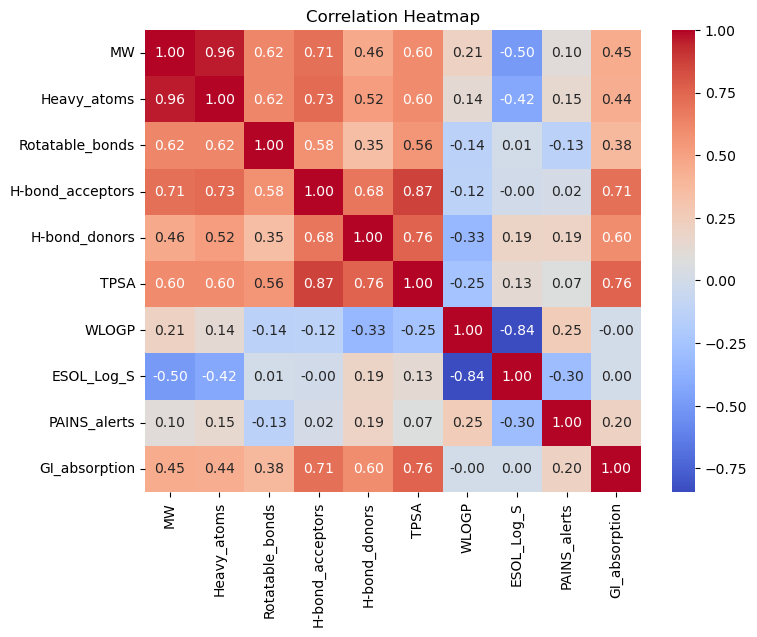

In [68]:
# ==== محاسبه و نمایش نقشه همبستگی ====

numeric_cols = features_to_plot + ['GI_absorption']
corr = df_encoded[numeric_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [70]:
# نمایش همبستگی ویژگی‌ها با هدف
corr_target = corr['GI_absorption'].sort_values(ascending=False)
print("Correlation with target:\n", corr_target)

Correlation with target:
 GI_absorption       1.000000
TPSA                0.758060
H-bond_acceptors    0.710979
H-bond_donors       0.595524
MW                  0.445536
Heavy_atoms         0.443717
Rotatable_bonds     0.376399
PAINS_alerts        0.204961
ESOL_Log_S          0.001490
WLOGP              -0.001263
Name: GI_absorption, dtype: float64


In [77]:
# ==== انتخاب ویژگی‌های مهم بر اساس همبستگی با هدف ====

n_features = 5
top_features = corr_target.index[1:n_features+1].tolist()
print("Selected features:", top_features)

df_selected = df_clean[top_features + ['GI_absorption']].copy()

# ذخیره داده‌های منتخب برای مدل‌سازی‌های بعدی
df_selected.to_csv('selected_features_for_modeling.csv', index=False)
print("Selected features saved to 'selected_features_for_modeling.csv'")

Selected features: ['TPSA', 'H-bond_acceptors', 'H-bond_donors', 'MW', 'Heavy_atoms']
Selected features saved to 'selected_features_for_modeling.csv'


In [83]:
print(df_selected.columns)

Index(['TPSA', 'H-bond_acceptors', 'H-bond_donors', 'MW', 'Heavy_atoms',
       'GI_absorption'],
      dtype='object')


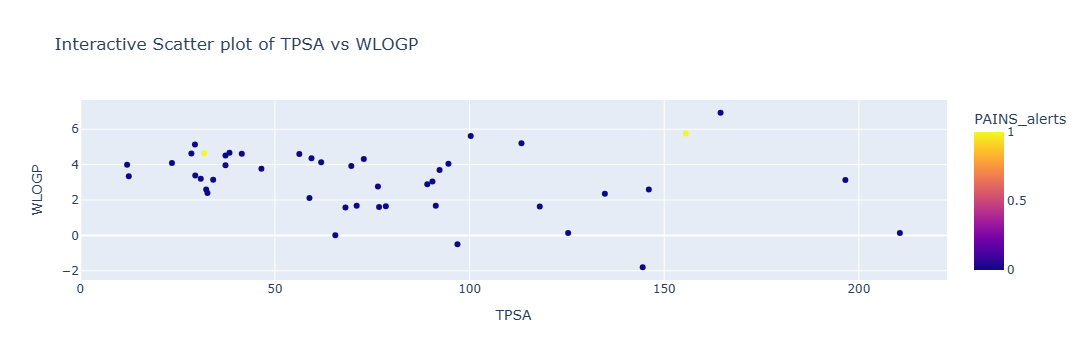

In [107]:
# ==== ترسیم گراف تعاملی با Plotly: Scatter plot TPSA vs WLOGP ====

fig = px.scatter(df_encoded, x='TPSA', y='WLOGP', color='PAINS_alerts',
                 labels={'WLOGP':'WLOGP', 'TPSA':'TPSA', 'PAINS_alerts':'PAINS_alerts'},
                 title='Interactive Scatter plot of TPSA vs WLOGP')
fig.show()

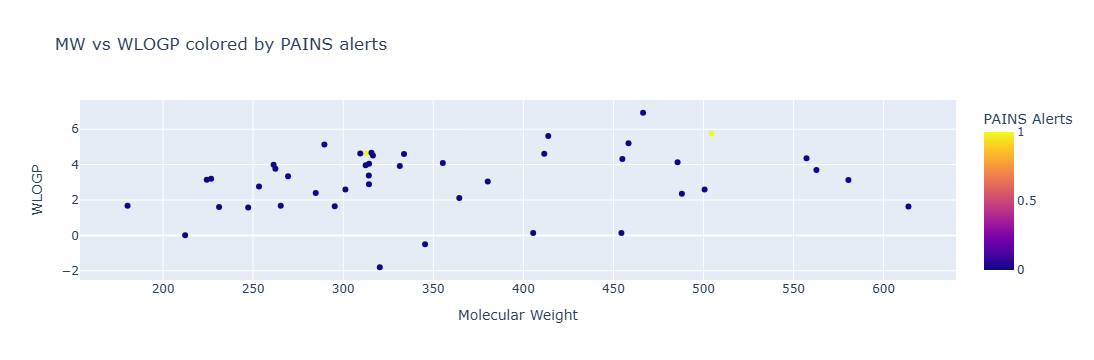

In [153]:
import plotly.express as px

fig1 = px.scatter(df_encoded,
                  x='MW',
                  y='WLOGP',
                  color='PAINS_alerts',
                  hover_name='Molecule',  # اگر نام ستون متفاوت است اصلاح کنید
                  labels={'MW': 'Molecular Weight', 'WLOGP': 'WLOGP', 'PAINS_alerts': 'PAINS Alerts'},
                  title='MW vs WLOGP colored by PAINS alerts')

fig1.show()

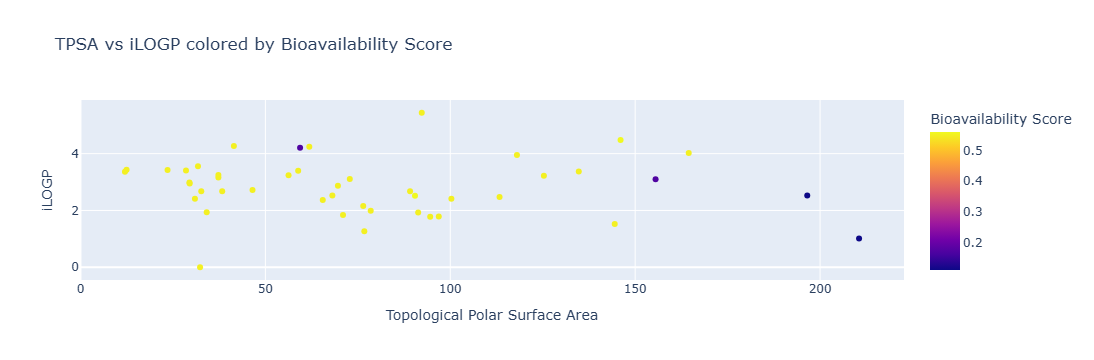

In [154]:
fig2 = px.scatter(df_encoded,
                  x='TPSA',
                  y='iLOGP',
                  color='Bioavailability_Score',
                  hover_name='Molecule',
                  labels={'TPSA': 'Topological Polar Surface Area', 'iLOGP': 'iLOGP', 'Bioavailability_Score': 'Bioavailability Score'},
                  title='TPSA vs iLOGP colored by Bioavailability Score')

fig2.show()

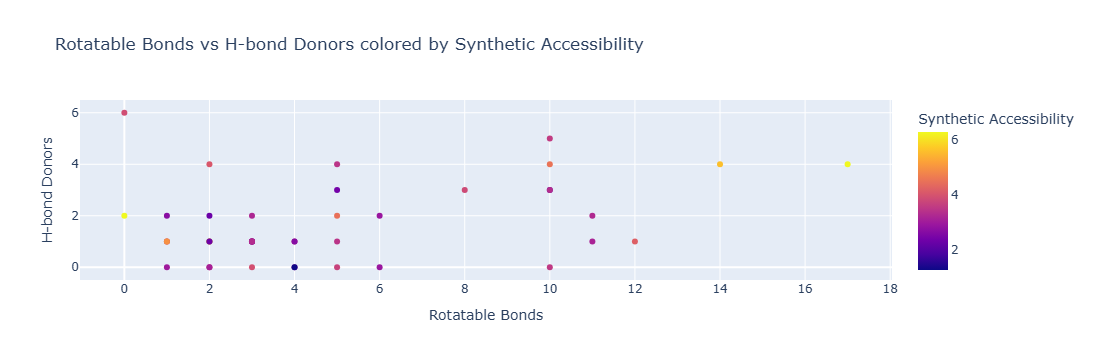

In [155]:
fig3 = px.scatter(df_encoded,
                  x='Rotatable_bonds',
                  y='H-bond_donors',
                  color='Synthetic_Accessibility',
                  hover_name='Molecule',
                  labels={'Rotatable_bonds': 'Rotatable Bonds', 'H-bond_donors': 'H-bond Donors', 'Synthetic_Accessibility': 'Synthetic Accessibility'},
                  title='Rotatable Bonds vs H-bond Donors colored by Synthetic Accessibility')

fig3.show()

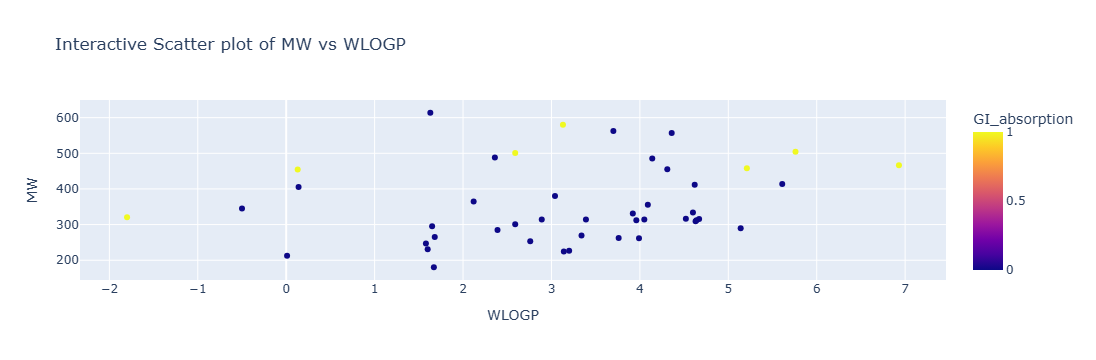

In [140]:
fig = px.scatter(df_encoded, x='WLOGP', y='MW', color='GI_absorption',
 labels={'WLOGP':'WLOGP', 'MW':'MW', 'GI_absorption':'GI_absorption'},
 title='Interactive Scatter plot of MW vs WLOGP')
fig.show()

Selected features: ['TPSA', 'H-bond_acceptors', 'H-bond_donors', 'MW', 'Heavy_atoms']


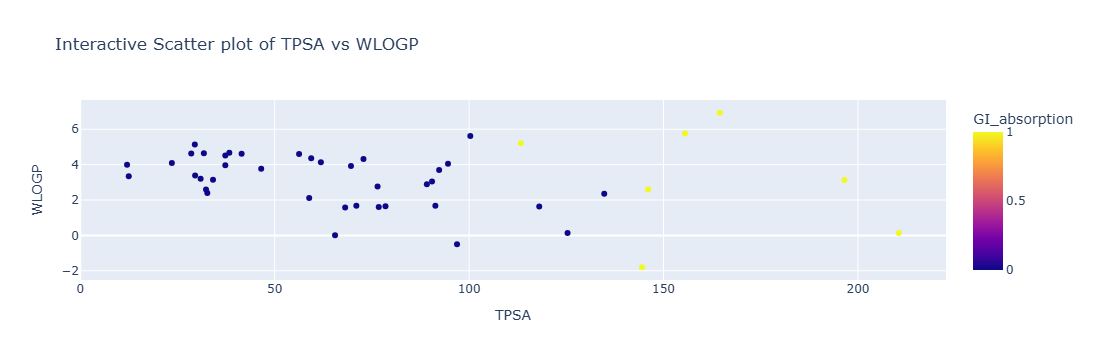

In [142]:
# انتخاب 5 ویژگی برتر بر اساس همبستگی
n_features = 5
top_features = corr_target.index[1:n_features+1].tolist()

# اگر TPSA در لیست نیست، اضافه‌اش کنیم
if 'TPSA' not in top_features:
    top_features.append('TPSA')

print("Selected features:", top_features)

df_selected = df_clean[top_features + ['BBB_permeant']].copy()

# ذخیره داده
df_selected.to_csv('selected_features_for_modeling.csv', index=False)

# ترسیم گراف تعاملی با Plotly
fig = px.scatter(df_encoded, x='TPSA', y='WLOGP', color='GI_absorption',
 labels={'WLOGP':'WLOGP', 'TPSA':'TPSA', 'BBB_permeant_bin':'BBB permeant'},
 title='Interactive Scatter plot of TPSA vs WLOGP')
fig.show()

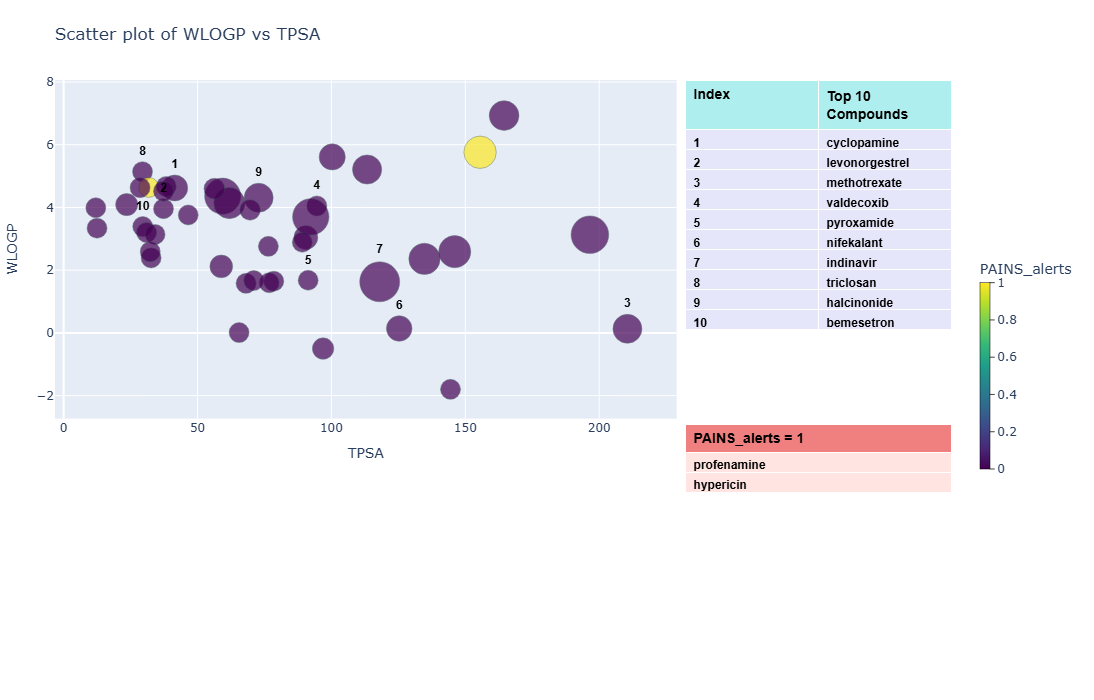

In [203]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# کپی داده‌ها و شماره‌گذاری 10 مورد اول
df_plot = df_encoded.copy()
df_plot['Index'] = ""
df_plot.loc[df_plot.index < 10, 'Index'] = (df_plot.index[df_plot.index < 10] + 1).astype(str)

df_top10 = df_plot.loc[df_plot.index < 10, ['Index', 'Molecule']].copy()
df_pains = df_plot[df_plot['PAINS_alerts'] == 1][['Molecule']].copy()  # استخراج مولکول‌هایی که PAINS_alerts=1 دارند

# نرمال‌سازی MW برای سایز نقاط
min_size = 10
max_size = 40
mw_min = df_plot['MW'].min()
mw_max = df_plot['MW'].max()

def normalize_size(mw):
    return min_size + (mw - mw_min) / (mw_max - mw_min) * (max_size - min_size)

sizes = df_plot['MW'].apply(normalize_size)

# ساخت شکل با 2 ستون و 2 ردیف (نمودار سمت چپ، جدول‌ها زیر هم در ستون سمت راست)
fig = make_subplots(
    rows=2, cols=2,
    specs=[
        [{"type": "scatter"}, {"type": "table"}],  # نمودار و جدول Top 10 در ردیف اول
        [None, {"type": "table"}]                 # جدول PAINS_alerts=1 در ردیف دوم
    ],
    column_widths=[0.7, 0.3],  # کاهش عرض جدول‌ها و افزایش عرض نمودار
    row_heights=[0.6, 0.4],  # تنظیم ارتفاع ردیف‌ها
    horizontal_spacing=0.01,
    vertical_spacing=0.01
)

# نمودار پراکندگی
scatter = go.Scatter(
    x=df_plot['TPSA'],
    y=df_plot['WLOGP'],
    mode='markers+text',
    text=df_plot['Index'],
    textposition='top center',
    textfont=dict(size=12, color='black', family="Arial", weight="bold"),  # بولد کردن اعداد داخل نمودار
    marker=dict(
        color=df_plot['PAINS_alerts'],
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(
            title='PAINS_alerts',
            len=0.4,
            thickness=10,
            outlinewidth=0.5,
            outlinecolor='black',
            ticks='outside'
        ),
        size=sizes,
        sizemode='diameter',
        sizemin=min_size,
        line=dict(width=0.5, color='DarkSlateGrey')
    ),
    hovertext=df_plot['Molecule'],
    hoverinfo='text+x+y'
)
fig.add_trace(scatter, row=1, col=1)

# جدول Top 10 در ستون سمت راست، ردیف اول
table_top10 = go.Table(
    header=dict(
        values=["Index", "Top 10 Compounds"],
        fill_color='paleturquoise',
        align='left',
        font=dict(size=14, color='black', family="Arial", weight="bold")  # بولد کردن سرصفحه جدول
    ),
    cells=dict(
        values=[df_top10['Index'], df_top10['Molecule']],
        fill_color='lavender',
        align='left',
        font=dict(size=12, color='black', family="Arial", weight="bold")  # بولد کردن مقادیر جدول
    )
)
fig.add_trace(table_top10, row=1, col=2)

# جدول PAINS_alerts=1 در ستون سمت راست، ردیف دوم
table_pains = go.Table(
    header=dict(
        values=["PAINS_alerts = 1"],
        fill_color='lightcoral',
        align='left',
        font=dict(size=14, color='black', family="Arial", weight="bold")  # بولد کردن سرصفحه جدول
    ),
    cells=dict(
        values=[df_pains['Molecule']],
        fill_color='mistyrose',
        align='left',
        font=dict(size=12, color='black', family="Arial", weight="bold")  # بولد کردن مقادیر جدول
    )
)
fig.add_trace(table_pains, row=2, col=2)

# تنظیم محورهای نمودار
fig.update_xaxes(title_text="TPSA", row=1, col=1)
fig.update_yaxes(title_text="WLOGP", row=1, col=1)

# تنظیمات کلی شکل
fig.update_layout(
    title_text="Scatter plot of WLOGP vs TPSA",
    height=700,  # افزایش ارتفاع برای نمایش بهتر جدول‌ها
    margin=dict(l=50, r=50, t=80, b=50),
    showlegend=False
)

fig.show()

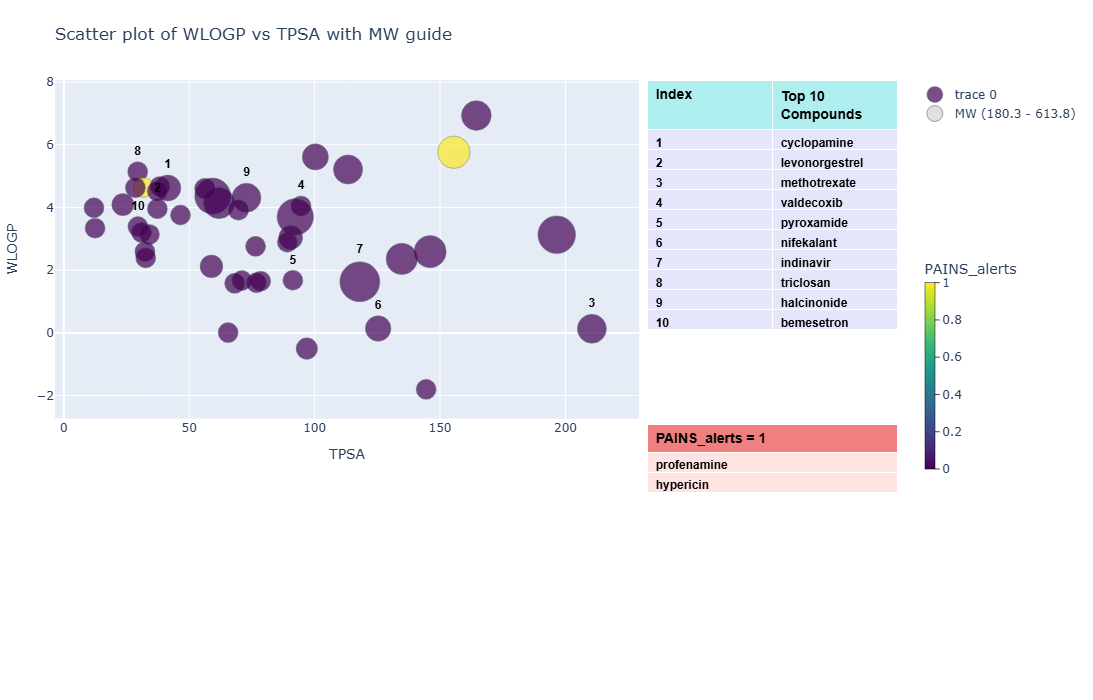

In [195]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# کپی داده‌ها و شماره‌گذاری 10 مورد اول
df_plot = df_encoded.copy()
df_plot['Index'] = ""
df_plot.loc[df_plot.index < 10, 'Index'] = (df_plot.index[df_plot.index < 10] + 1).astype(str)

df_top10 = df_plot.loc[df_plot.index < 10, ['Index', 'Molecule']].copy()
df_pains = df_plot[df_plot['PAINS_alerts'] == 1][['Molecule']].copy()  # استخراج مولکول‌هایی که PAINS_alerts=1 دارند

# نرمال‌سازی MW برای سایز نقاط
min_size = 10
max_size = 40
mw_min = df_plot['MW'].min()
mw_max = df_plot['MW'].max()

def normalize_size(mw):
    return min_size + (mw - mw_min) / (mw_max - mw_min) * (max_size - min_size)

sizes = df_plot['MW'].apply(normalize_size)

# ساخت شکل با 2 ستون و 2 ردیف (نمودار سمت چپ، جدول‌ها زیر هم در ستون سمت راست)
fig = make_subplots(
    rows=2, cols=2,
    specs=[
        [{"type": "scatter"}, {"type": "table"}],  # نمودار و جدول Top 10 در ردیف اول
        [None, {"type": "table"}]                 # جدول PAINS_alerts=1 در ردیف دوم
    ],
    column_widths=[0.7, 0.3],  # کاهش عرض جدول‌ها و افزایش عرض نمودار
    row_heights=[0.6, 0.4],  # تنظیم ارتفاع ردیف‌ها
    horizontal_spacing=0.01,
    vertical_spacing=0.01
)

# نمودار پراکندگی
scatter = go.Scatter(
    x=df_plot['TPSA'],
    y=df_plot['WLOGP'],
    mode='markers+text',
    text=df_plot['Index'],
    textposition='top center',
    textfont=dict(size=12, color='black', family="Arial", weight="bold"),  # بولد کردن اعداد داخل نمودار
    marker=dict(
        color=df_plot['PAINS_alerts'],
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(
            title='PAINS_alerts',
            len=0.4,
            thickness=10,
            outlinewidth=0.5,
            outlinecolor='black',
            ticks='outside'
        ),
        size=sizes,
        sizemin=min_size,  # حذف sizeref
        line=dict(width=0.5, color='DarkSlateGrey')
    ),
    hovertext=df_plot['Molecule'],
    hoverinfo='text+x+y'
)
fig.add_trace(scatter, row=1, col=1)

# جدول Top 10 در ستون سمت راست، ردیف اول
table_top10 = go.Table(
    header=dict(
        values=["Index", "Top 10 Compounds"],
        fill_color='paleturquoise',
        align='left',
        font=dict(size=14, color='black', family="Arial", weight="bold")  # بولد کردن سرصفحه جدول
    ),
    cells=dict(
        values=[df_top10['Index'], df_top10['Molecule']],
        fill_color='lavender',
        align='left',
        font=dict(size=12, color='black', family="Arial", weight="bold")  # بولد کردن مقادیر جدول
    )
)
fig.add_trace(table_top10, row=1, col=2)

# جدول PAINS_alerts=1 در ستون سمت راست، ردیف دوم
table_pains = go.Table(
    header=dict(
        values=["PAINS_alerts = 1"],
        fill_color='lightcoral',
        align='left',
        font=dict(size=14, color='black', family="Arial", weight="bold")  # بولد کردن سرصفحه جدول
    ),
    cells=dict(
        values=[df_pains['Molecule']],
        fill_color='mistyrose',
        align='left',
        font=dict(size=12, color='black', family="Arial", weight="bold")  # بولد کردن مقادیر جدول
    )
)
fig.add_trace(table_pains, row=2, col=2)

# اضافه کردن راهنمای MW به شکل
fig.add_trace(
    go.Scatter(
        x=[None], y=[None],  # نقاطی برای نمایش در راهنما، بدون موقعیت در نمودار اصلی
        mode='markers',
        marker=dict(
            size=[min_size, max_size],  # سایز نقاط برای نمایش حداقل و حداکثر MW
            color='lightgray',
            sizemode='diameter',  # فقط یکبار تعریف شده
            line=dict(width=0.5, color='black')
        ),
        showlegend=True,
        name=f'MW ({mw_min:.1f} - {mw_max:.1f})'  # نمایش محدوده MW
    )
)

# تنظیم محورهای نمودار
fig.update_xaxes(title_text="TPSA", row=1, col=1)
fig.update_yaxes(title_text="WLOGP", row=1, col=1)

# تنظیمات کلی شکل
fig.update_layout(
    title_text="Scatter plot of WLOGP vs TPSA with MW guide",
    height=700,  # افزایش ارتفاع برای نمایش بهتر جدول‌ها
    margin=dict(l=50, r=50, t=80, b=50),
    showlegend=True
)

fig.show()

In [ ]:
# ==== آماده سازی داده‌ها برای مدل‌سازی ====

X = df_selected.drop(columns=['Target'])
y = df_selected['Target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# انتخاب فقط ستون‌های عددی (بدون هدف چون unsupervised)
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

# حذف ردیف‌های دارای داده گمشده در ستون‌های عددی
df_clean = df.dropna(subset=numeric_cols)

# آماده‌سازی داده عددی
X = df_clean[numeric_cols].copy()

# استانداردسازی داده‌ها (مهم برای واریانس و PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# حذف ستون هدف از لیست ویژگی‌ها چون برای کلاسترینگ استفاده نمی‌شود
if 'Target' in numeric_cols:
    numeric_cols.remove('Target')

In [ ]:
# حذف ردیف‌هایی که در ستون‌های عددی یا هدف داده گمشده دارند
df_clean = df.dropna(subset=numeric_cols + ['Target'])

In [ ]:


# --- انتخاب ویژگی بر اساس واریانس ---

# مقدار آستانه واریانس را تنظیم کنید (مثلاً 0.5)
threshold = 0.5
selector = VarianceThreshold(threshold=threshold)
selector.fit(X_scaled)

# ماسک ویژگی‌هایی که واریانس بالاتر از آستانه دارند
features_selected_mask = selector.get_support()

# نام ویژگی‌های انتخاب شده
features_selected = np.array(numeric_cols)[features_selected_mask]

print(f"Features selected by VarianceThreshold (>{threshold}):")
for i, feat in enumerate(features_selected, 1):
    print(f"{i}. {feat}")

# --- رتبه‌بندی ویژگی‌ها بر اساس واریانس ---

# واریانس هر ویژگی (روی داده استاندارد نشده)
variances = X.var(axis=0)
variance_ranking = pd.Series(variances, index=numeric_cols).sort_values(ascending=False)

print("\nTop 10 features by variance:")
print(variance_ranking.head(10))

# --- کاهش ابعاد با PCA ---

pca = PCA()
pca.fit(X_scaled)

explained_variance_ratio = pca.explained_variance_ratio_

# درصد واریانس توضیح داده شده توسط هر کامپوننت
print("\nExplained variance ratio by PCA components:")
for i, var_ratio in enumerate(explained_variance_ratio[:10], 1):
    print(f"Component {i}: {var_ratio:.4f}")

# --- پیشنهاد: انتخاب تعداد کامپوننتی که مثلاً 90% واریانس را پوشش می‌دهد ---
cumulative_variance = np.cumsum(explained_variance_ratio)
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f"\nNumber of PCA components to explain 90% variance: {n_components_90}")

In [ ]:


# ---------- 1. بارگذاری داده و اصلاح نام ستون‌ها ----------
df = pd.read_csv('swissadme.csv')
df.columns = df.columns.str.strip().str.replace('#', '').str.replace(' ', '_')

# ---------- 2. انتخاب فقط ستون‌های عددی ----------
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

# حذف ردیف‌های دارای داده گمشده در ستون‌های عددی
df_clean = df.dropna(subset=numeric_cols)

X = df_clean[numeric_cols].copy()

# ---------- 3. استانداردسازی داده‌ها ----------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------- 4. انتخاب ویژگی بر اساس واریانس ----------
threshold = 0.5
selector = VarianceThreshold(threshold=threshold)
selector.fit(X_scaled)

features_selected_mask = selector.get_support()
features_selected = np.array(numeric_cols)[features_selected_mask]

print(f"Selected features (variance > {threshold}):")
for i, feat in enumerate(features_selected, 1):
    print(f"{i}. {feat}")

X_selected = df_clean[features_selected]

# استانداردسازی مجدد ویژگی‌های منتخب
X_selected_scaled = scaler.fit_transform(X_selected)

# ---------- 5. اجرای K-Means ----------
k = 4  # تعداد خوشه‌ها (می‌توانید عدد را تغییر دهید)

kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_selected_scaled)

# اضافه کردن برچسب خوشه به داده اصلی برای بررسی
df_clean['KMeans_Cluster'] = kmeans_labels

# ---------- 6. اجرای Hierarchical Clustering ----------
hierarchical = AgglomerativeClustering(n_clusters=k)
hier_labels = hierarchical.fit_predict(X_selected_scaled)

df_clean['Hierarchical_Cluster'] = hier_labels

# ---------- 7. ترسیم نمودارهای خوشه‌بندی ----------

# نمودار K-Means با دو بعد اول PCA برای نمایش
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_selected_scaled)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=kmeans_labels, palette='Set1', s=60)
plt.title('K-Means Clustering (PCA projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')

# نمودار Hierarchical Clustering
plt.subplot(1,2,2)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=hier_labels, palette='Set2', s=60)
plt.title('Hierarchical Clustering (PCA projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')

plt.tight_layout()
plt.show()

# ---------- 8. رسم دندروگرام برای خوشه‌بندی هیراکلارکی ----------

linked = linkage(X_selected_scaled, method='ward')

plt.figure(figsize=(10, 6))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=False)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

In [ ]:
# اگر ستون نام نمونه دارید، مثلاً 'Sample_Name'
if 'Sample_Name' in df_clean.columns:
    names = df_clean['Sample_Name']
else:
    # در غیر این صورت از اندیس ردیف‌ها به عنوان نام نمونه استفاده می‌کنیم
    names = df_clean.index.astype(str)

In [ ]:
clusters_df = pd.DataFrame({
    'Sample_Name': names,
    'KMeans_Cluster': df_clean['KMeans_Cluster'],
    'Hierarchical_Cluster': df_clean['Hierarchical_Cluster']
})

# نمایش 10 نمونه اول
print(clusters_df.head(10))

# ذخیره به فایل CSV (اختیاری)
clusters_df.to_csv('samples_with_clusters.csv', index=False)
print("Saved sample names and cluster labels to 'samples_with_clusters.csv'")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# فرض: df_selected همان دیتا فریم شامل ویژگی‌های منتخب است
# اگر هنوز df_selected را ندارید، مثلاً:
# df_selected = df_clean[features_selected].copy()

# محاسبه ماتریس همبستگی
corr_matrix = df_selected.corr()

# رسم هیت‌مپ
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True,
            cbar_kws={"shrink": .75}, linewidths=0.5)

plt.title('Correlation Heatmap of Selected Features')
plt.show()

In [ ]:
df_selected = df_clean[features_selected].copy()
# سپس کد بالا را اجرا کنید

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# فرض: df_selected همان دیتا فریم شامل ویژگی‌های منتخب است
# اگر هنوز df_selected را ندارید، مثلاً:
# df_selected = df_clean[features_selected].copy()

# محاسبه ماتریس همبستگی
corr_matrix = df_selected.corr()

# رسم هیت‌مپ
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True,
            cbar_kws={"shrink": .75}, linewidths=0.5)

plt.title('Correlation Heatmap of Selected Features')
plt.show()

In [ ]:
features_to_plot = ['MW', 'TPSA', 'WLOGP', 'iLOGP', 'Rotatable bonds', 'H-bond acceptors', 'H-bond donors']

plt.figure(figsize=(15,10))
for i, feature in enumerate(features_to_plot):
    plt.subplot(2, 4, i+1)
    sns.histplot(df_clean[feature], kde=True, color='blue')
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(15,8))
sns.boxplot(data=df_clean[features_to_plot])
plt.title('Boxplot of selected features')
plt.xticks(rotation=45)
plt.show()

In [ ]:
plt.figure(figsize=(18,15))
corr = df_clean.corr()

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
top_features = corr_target.abs().sort_values(ascending=False).index[1:11] # ۱۰ ویژگی برتر به جز هدف

plt.figure(figsize=(10,6))
sns.barplot(x=corr_target[top_features].values, y=top_features)
plt.title('Top Correlated Features with BBB permeant')
plt.xlabel('Correlation coefficient')
plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# انتخاب ویژگی‌های عددی
X = df_clean[numeric_cols].dropna()

# استانداردسازی
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Features')
plt.show()

# Pairplot برای چند ویژگی منتخب
sns.pairplot(df_clean[features_to_plot + ['BBB permeant']], hue='BBB permeant')
plt.show()

In [ ]:
import pandas as pd

# فرض می‌کنیم df_clean و ستون هدف 'BBB permeant_bin' وجود دارد

# ۱. محاسبه همبستگی با هدف
corr_target = df_clean.corr()['BBB permeant_bin'].abs().sort_values(ascending=False)

# ۲. انتخاب n ویژگی با بیشترین همبستگی (به جز خود هدف)
n_features = 10
top_features = corr_target.index[1:n_features+1].tolist()

print("Selected features:", top_features)

# ۳. ساخت DataFrame شامل فقط ویژگی‌های منتخب به همراه هدف
df_selected = df_clean[top_features + ['BBB permeant_bin']].copy()

# نمایش نمونه‌ای از داده‌ها
print(df_selected.head())

# ۴. ذخیره در فایل CSV برای استفاده‌های بعدی
df_selected.to_csv('selected_features_for_modeling.csv', index=False)
print("Selected features saved to 'selected_features_for_modeling.csv'")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# X و y تعریف می‌شوند
X = df_selected.drop(columns=['BBB permeant_bin'])
y = df_selected['BBB permeant_bin']

# تقسیم داده‌ها به آموزش و تست (مثلاً 80% آموزش، 20% تست)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# استانداردسازی داده‌ها (میانگین صفر و واریانس یک)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data is prepared and scaled for modeling.")

In [ ]:
# DataFrame نمونه با ویژگی‌های مورد نظر
fig = px.scatter(df_selected, x='WLOGP', y='TPSA', color='BBB permeant_bin',
                 labels={'WLOGP':'WLOGP', 'TPSA':'TPSA', 'BBB permeant_bin':'BBB permeant'},
                 title='Interactive Scatter plot of TPSA vs WLOGP')

fig.show()

In [ ]:
corr_matrix = df_selected.corr()

fig = ff.create_annotated_heatmap(
 z=corr_matrix.values,
 x=list(corr_matrix.columns),
 y=list(corr_matrix.index),
 colorscale='Viridis'
)

fig.update_layout(title_text='Interactive Correlation Heatmap')
fig.show()

In [ ]:
# لیست نمونه SMILES و نام‌ها
molecules = [
    ("CC1CC2C(C(C3(O2)CCC4C5CC=C6CC(CCC6(C5CC4=C3C)C)O)C)NC1", "cyclopamine"),
    ("CCC12CCC3C(C1CCC2(C#C)O)CCC4=CC(=O)CCC34", "levonorgestrel"),
    ("CN(CC1=CN=C2C(=N1)C(=NC(=N2)N)N)C3=CC=C(C=C3)C(=O)NC(CCC(=O)O)C(=O)O", "methotrexate"),
    # اضافه کنید ...
]

wlogp_list = []
tpsa_list = []
names = []

for smi, name in molecules:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        wlogp = Crippen.MolLogP(mol)  # محاسبه LogP
        tpsa = rdMolDescriptors.CalcTPSA(mol)  # محاسبه TPSA
        wlogp_list.append(wlogp)
        tpsa_list.append(tpsa)
        names.append(name)
    else:
        print(f"Failed to parse: {name}")

# رسم نمودار BOILED-Egg ساده

plt.figure(figsize=(8,6))
plt.scatter(wlogp_list, tpsa_list, c='orange', edgecolors='k')

# محدوده های تقریبی BOILED-Egg (مقادیر تقریبی از مقاله BOILED-Egg)
# محدوده BBB
plt.fill_betweenx(y=[0, 90], x1=-1, x2=1.5, color='yellow', alpha=0.3, label='BBB+ zone')

# محدوده HIA
plt.fill_betweenx(y=[20, 130], x1=-0.7, x2=5, color='white', alpha=0.3, label='HIA+ zone')

plt.xlabel('WLOGP')
plt.ylabel('TPSA')
plt.title('Simple BOILED-Egg Plot')
plt.legend()

# نوشتن نام مولکول‌ها روی نقاط
for i, name in enumerate(names):
    plt.text(wlogp_list[i], tpsa_list[i], name, fontsize=8)

plt.grid(True)
plt.show()